In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import glob
import random
from tqdm import tqdm
import shutil
from PIL import Image
import imghdr

2025-04-27 02:41:18.570187: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745721678.831441      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745721678.905919      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_31/342400264.py:20: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [15]:
# Define paths
dataset_path = "/kaggle/input/garbage-classification-v2/garbage-dataset"
class_names = os.listdir(dataset_path)
print("Classes:", class_names)

Classes: ['metal', 'glass', 'biological', 'paper', 'battery', 'trash', 'cardboard', 'shoes', 'clothes', 'plastic']


In [3]:
# 1. Data Preprocessing
def clean_dataset(dataset_path):
    """Remove corrupted/non-image files and create clean dataset"""
    clean_path = "/kaggle/working/clean"
    os.makedirs(clean_path, exist_ok=True)
    
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path):
            continue
            
        clean_class_path = os.path.join(clean_path, class_name)
        os.makedirs(clean_class_path, exist_ok=True)
        
        for img_file in tqdm(os.listdir(class_path)):
            img_path = os.path.join(class_path, img_file)
            
            try:
                # Check if file is an image
                if not imghdr.what(img_path):
                    continue
                
                # Try to open the image
                img = Image.open(img_path)
                img.verify()
                
                # Convert to RGB if needed
                img = Image.open(img_path)
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                
                # Save to clean directory
                img.save(os.path.join(clean_class_path, img_file))
                
            except (IOError, OSError, Image.DecompressionBombError):
                print(f"Removing corrupted file: {img_path}")
                continue
    
    return clean_path

In [4]:
# 2. Class Balancing
def balance_dataset(clean_path, target_samples_per_class=1000):
    """Balance dataset by random undersampling"""
    balanced_path = "/kaggle/working/balanced"
    os.makedirs(balanced_path, exist_ok=True)
    
    class_counts = {}
    for class_name in os.listdir(clean_path):
        class_path = os.path.join(clean_path, class_name)
        if not os.path.isdir(class_path):
            continue
            
        # Count images per class
        image_files = os.listdir(class_path)
        class_counts[class_name] = len(image_files)
        
        # Create balanced directory
        balanced_class_path = os.path.join(balanced_path, class_name)
        os.makedirs(balanced_class_path, exist_ok=True)
        
        # Undersample if needed
        if len(image_files) > target_samples_per_class:
            image_files = random.sample(image_files, target_samples_per_class)
        
        # Copy selected images
        for img_file in image_files:
            src = os.path.join(class_path, img_file)
            dst = os.path.join(balanced_class_path, img_file)
            shutil.copy(src, dst)
    
    print("Class distribution after balancing:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {min(count, target_samples_per_class)} samples")
    
    return balanced_path

In [5]:
# 3. Data Loading and Augmentation
def create_data_generators(balanced_path, img_size=(224, 224), batch_size=64):
    """Create data generators with augmentation"""
    # Create dataframe
    image_paths = []
    labels = []
    
    for class_name in os.listdir(balanced_path):
        class_path = os.path.join(balanced_path, class_name)
        if not os.path.isdir(class_path):
            continue
            
        for img_file in os.listdir(class_path):
            image_paths.append(os.path.join(class_path, img_file))
            labels.append(class_name)
    
    df = pd.DataFrame({"image_path": image_paths, "label": labels})
    
    # Split into train, val, test
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
    train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])
    
    # Calculate class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
    class_weights = dict(enumerate(class_weights))
    
    # Data augmentation
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8, 1.2],
        # fill_mode="nearest",
        preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
    )
    
    val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input)
    
    # Create generators
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="image_path",
        y_col="label",
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col="image_path",
        y_col="label",
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False
    )
    
    test_generator = val_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col="image_path",
        y_col="label",
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False
    )
    
    return train_generator, val_generator, test_generator, class_weights

In [6]:
# 4. Model Building
def build_model(input_shape, num_classes):
    """Build EfficientNetV2S model with custom head"""
    base_model = tf.keras.applications.EfficientNetV2S(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=None
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [7]:
# 5. Training
def train_model(train_generator, val_generator, class_weights):
    """Train the model with callbacks"""
    input_shape = (224, 224, 3)
    num_classes = len(train_generator.class_indices)
    
    model = build_model(input_shape, num_classes)
    
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    callbacks = [
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)
    ]
    
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=30,
        callbacks=callbacks,
        class_weight=class_weights
    )
    
    return model, history

In [8]:
# 6. Evaluation
def evaluate_model(model, test_generator):
    """Evaluate model performance"""
    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_acc:.4f}")
    
    # Classification report
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes
    
    class_names = list(test_generator.class_indices.keys())
    print(classification_report(y_true, y_pred_classes, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.show()
    
    return test_acc

In [9]:
print("1. Cleaning dataset...")
clean_path = clean_dataset(dataset_path)

1. Cleaning dataset...


100%|██████████| 1984/1984 [00:32<00:00, 61.18it/s] 


In [10]:
# !rm -rf /kaggle/working/*

In [11]:
print("\n2. Balancing classes...")
balanced_path = balance_dataset(clean_path, target_samples_per_class=1000)


2. Balancing classes...
Class distribution after balancing:
paper: 1000 samples
battery: 944 samples
metal: 1000 samples
plastic: 1000 samples
glass: 1000 samples
trash: 947 samples
biological: 997 samples
cardboard: 1000 samples
clothes: 1000 samples
shoes: 1000 samples


In [14]:
class_names_balanced = os.listdir(balanced_path)
print("Classes:", class_names_balanced)

Classes: ['paper', 'battery', 'metal', 'plastic', 'glass', 'trash', 'biological', 'cardboard', 'clothes', 'shoes']


In [13]:
print("\n3. Creating data generators...")
train_generator, val_generator, test_generator, class_weights = create_data_generators(balanced_path)


3. Creating data generators...
Found 6328 validated image filenames belonging to 10 classes.
Found 1582 validated image filenames belonging to 10 classes.
Found 1978 validated image filenames belonging to 10 classes.


In [13]:
print("\n4. Building and training model...")
model, history = train_model(train_generator, val_generator, class_weights)


4. Building and training model...


I0000 00:00:1745716459.945039      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745716459.945715      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745716505.197516      92 service.cc:148] XLA service 0x7faf900a0310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745716505.198647      92 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745716505.198669      92 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745716508.836567      92 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745716530.579147      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

99/99 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.6815 - loss: 1.0472 - val_accuracy: 0.9064 - val_loss: 0.3122 - learning_rate: 0.0010
Epoch 2/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 88s 825ms/step - accuracy: 0.8868 - loss: 0.3659 - val_accuracy: 0.9197 - val_loss: 0.2587 - learning_rate: 0.0010
Epoch 3/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 87s 824ms/step - accuracy: 0.9007 - loss: 0.3098 - val_accuracy: 0.9267 - val_loss: 0.2476 - learning_rate: 0.0010
Epoch 4/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 88s 835ms/step - accuracy: 0.9018 - loss: 0.2913 - val_accuracy: 0.9216 - val_loss: 0.2368 - learning_rate: 0.0010
Epoch 5/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 87s 819ms/step - accuracy: 0.9166 - loss: 0.2395 - val_accuracy: 0.9241 - val_loss: 0.2271 - learning_rate: 0.0010
Epoch 6/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 87s 814ms/step - accuracy: 0.9306 - loss: 0.2215 - val_accuracy: 0.9324 - val_loss: 0.2147 - learning_rate: 0.0010
Epoch 7/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 87s 823ms/step - accuracy: 0.9319 - loss: 0.2114 - val_ac


5. Evaluating model...
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 443ms/step - accuracy: 0.9222 - loss: 0.2138
Test Accuracy: 0.9272
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 551ms/step
              precision    recall  f1-score   support

     battery       0.95      0.96      0.96       189
  biological       0.99      0.99      0.99       200
   cardboard       0.90      0.94      0.92       200
     clothes       0.98      0.98      0.98       200
       glass       0.86      0.93      0.89       200
       metal       0.90      0.90      0.90       200
       paper       0.93      0.91      0.92       200
     plastic       0.91      0.81      0.86       200
       shoes       0.99      0.99      0.99       200
       trash       0.88      0.87      0.87       189

    accuracy                           0.93      1978
   macro avg       0.93      0.93      0.93      1978
weighted avg       0.93      0.93      0.93      1978



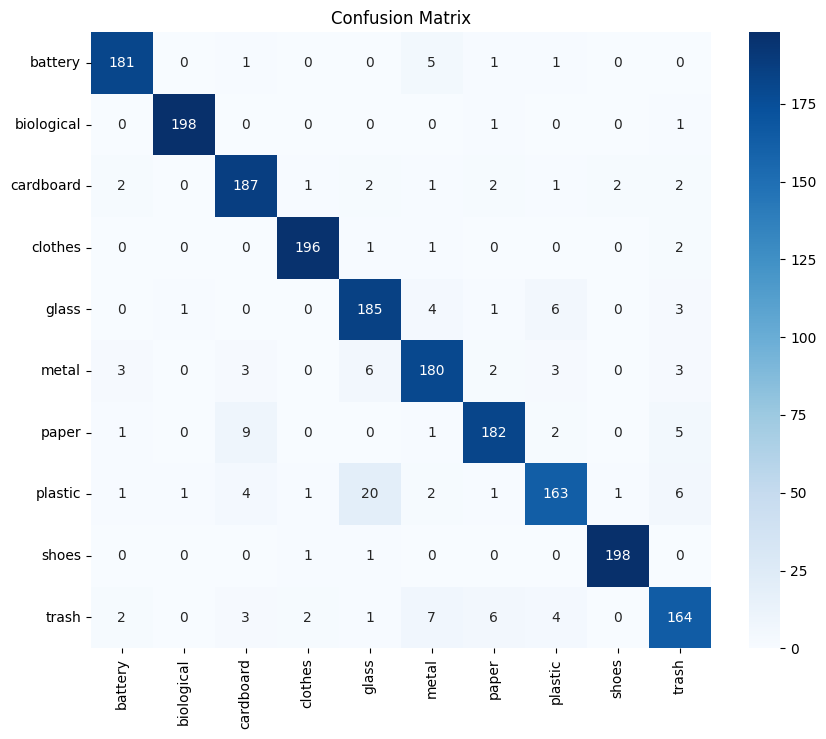

In [14]:
print("\n5. Evaluating model...")
test_acc = evaluate_model(model, test_generator)

In [16]:
model.save('EffNetV2S.h5')

In [15]:
def classify_waste(image_path, model):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0
    img = tf.expand_dims(img, axis=0)
    
    preds = model.predict(img)
    pred_class = class_names[np.argmax(preds)]
    confidence = np.max(preds)
    
    return pred_class, confidence

# Test with a sample image
sample_image = random.choice(test_df["image_path"].values)
pred_class, confidence = classify_waste(sample_image, model)

print(f"Image: {os.path.basename(sample_image)}")
print(f"Predicted: {pred_class} (Confidence: {confidence:.2f})")

# Display the image
img = plt.imread(sample_image)
plt.imshow(img)
plt.title(f"Predicted: {pred_class} ({confidence:.2f})")
plt.axis("off")
plt.show()


NameError: name 'test_df' is not defined